In [1]:
import matplotlib.pyplot as plt
import pdb
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 22
import numpy as np
from embeddings import load_embeddings
from lower_bound import lower_bound
from mechanism_base import OPTMech, ExponentialMechanism, EuclideanMechanism, ConstrOPTMech
from constr_mech import ExpConstrOPTMech
from tqdm import tqdm
import time
import pickle
import sys

In [2]:
from run_experiments import get_data_once, get_actual_epsilon

def get_data(mech, epsilons, save_path = None, stop_after = np.inf):
    res = []
    for e in epsilons:
        print(e)
        sys.stdout.flush()
        mech.epsilon = e 
        r = get_data_once(mech)
        res.append(r)
        if r['success'] and r['epsilon'] > stop_after:
            break

    res_dict = {}
    for i in range(0, len(res)):
        for k, v in res[i].items():
            if k in res_dict:
                res_dict[k].append(v)
            else:
                res_dict[k] = [v] 
    res_dict['name'] = mech.name
    res_dict['distance_matrix'] = mech.embeddings.distance_matrix
    if save_path is not None:
        pickle.dump(res_dict, open(save_path, 'wb'))
    return res_dict

In [3]:
exp_label = 'ExpMech'
opt_label = 'OPTMech'
constr_label = 'ConstrOPTMech'
spanner_label = 'SpannerMech'
weighted_label = 'WeightedExpMech'
euclid_label = 'EuclidMech'

In [4]:
emb = load_embeddings('data/fasttext_sample_1000_0.5.txt', 50)
emb.save_ann()

In [28]:
euclid_mech = EuclideanMechanism(1.0, 10000, emb, True)
#euclid_data = get_data(euclid_mech, np.geomspace(1, 70.0, 10), 'data/50pts/fasttext/euclid_data.pkl')
euclid_data = pickle.load(open('data/50pts/fasttext/euclid_data.pkl', 'rb'))
euclid_data['name'] = euclid_label

In [29]:
exp_mech = ExponentialMechanism(1.0, emb)
exp_data = get_data(exp_mech, np.geomspace(0.05, 10.0, 20))
exp_data['name'] = exp_label

0.05
0.0660810364716802
0.08733406762343063
0.1154225141568821
0.15254478735307905
0.20160635313287043
0.266447135485913
0.3521420575563868
0.4653982429719222
0.6150799653536696
0.8129024324707131
1.074348705760295
1.4198815201729695
1.8765448504002957
2.4800805740009126
3.2777258972651993
4.331910491227047
5.725142703256576
7.566467275589428
10.0


In [30]:
opt_mech = OPTMech(1.0, emb)
#opt_data = get_data(opt_mech, np.geomspace(0.1, 5.1, 10), 'data/50pts/fasttext/opt_data.pkl')
opt_data = pickle.load(open('data/50pts/fasttext/opt_data.pkl', 'rb'))
opt_data['name'] = opt_label

In [8]:
spanner, _ = emb.get_spanner(2.0)
spanner_opt_mech = OPTMech(1.0, emb, spanner)
#span_data = get_data(spanner_opt_mech, np.geomspace(0.1, 4.1, 10), 'data/50pts/fasttext/spanner_data.pkl')
span_data = pickle.load(open('data/50pts/fasttext/spanner_data.pkl', 'rb'))
span_data['name'] = spanner_label

In [9]:
constr_opt_mech = ConstrOPTMech(1.0, emb, [0.001, 0.1, 1.0])
constr_opt_mech.set_nns_heuristic(5)
#constr_data = get_data(constr_opt_mech, np.geomspace(0.1, 10.1, 10), 'data/50pts/fasttext/constr_data.pkl')
constr_data = pickle.load(open('data/50pts/fasttext/constr_data.pkl', 'rb'))
constr_data['name'] = constr_label

In [10]:
epsilons_lb = np.linspace(0.1, 5.1, 10)
lb = lower_bound(emb.distance_matrix, epsilons_lb)

In [11]:
result_list = [exp_data, constr_data, span_data, opt_data]

In [7]:
def correct_data(x, y):
    idxs = np.argsort(x)
    lowest = y[idxs[0]]
    include = [True]
    for i in range(1, len(x)):
        if y[idxs[i]] < lowest:
            lowest = y[idxs[i]]
            include.append(True)
        else:
            include.append(False)
    return idxs[include]

def plot_mech(mech, ax, utility_quantile, delta):
    if 'epsilon_correct' in mech:
        x = mech['epsilon_correct'].copy()
    else:
        x = np.array( [get_actual_epsilon(x, mech['distance_matrix'], delta).max() for x in mech['trans']] )
        mech['epsilon_correct'] = x.copy()
    #x = np.array(mech['epsilon'])
    y = np.array(mech['utility'])
    y = np.quantile(y, utility_quantile, axis=1)
    include = correct_data(x,y)
    x = x[include]
    y = y[include]
    ax.plot(x, y, label=mech['name'])
    #ax.fill_between(x, y0, y1, alpha=0.3, label = mech['name'], color=color)
    plt.legend()

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel('Epsilon')
ax.set_ylabel('Loss')
ax.set_title('Algorithm Loss for 50 Word Sample of FastText')
ax.hlines(np.quantile(emb.distance_matrix.mean(axis=1), 0.95), 0, 5.0, color='k', linestyles='dashed', alpha=0.8)
plot_mech(euclid_data, ax, 0.95, 0.002)
for res in result_list:
    plot_mech(res, ax, 0.95, 0.001)
ax.set_xlim(0, 4.0)
ax.plot(epsilons_lb, lb, 'k-.', label='Lower Bound')
ax.legend()

/home/jimola/dptextgeometry/run_experiments.py:298: RuntimeWarning: divide by zero encountered in log
  eps = np.log(ratios[idxs[cutoff]]) / d
/home/jimola/dptextgeometry/run_experiments.py:298: RuntimeWarning: divide by zero encountered in log
  eps = np.log(ratios[idxs[cutoff]]) / d


In [14]:
emb = load_embeddings('data/fasttext_sample_1000_0.5.txt', 200)

In [15]:
exp_data = pickle.load(open('data/200pts/fasttext/exp_data.pkl', 'rb'))
exp_data['name'] = exp_label
constr_data = pickle.load(open('data/200pts/fasttext/constr_data_10.pkl', 'rb'))
constr_data['name'] = constr_label
span_data = pickle.load(open('data/200pts/fasttext/spanner_data.pkl', 'rb'))
span_data['name'] = spanner_label
euclid_data = pickle.load(open('data/200pts/fasttext/euclid_data.pkl', 'rb'))
euclid_data['name'] = euclid_label

In [16]:
lb = lower_bound(emb.distance_matrix, epsilons_lb)

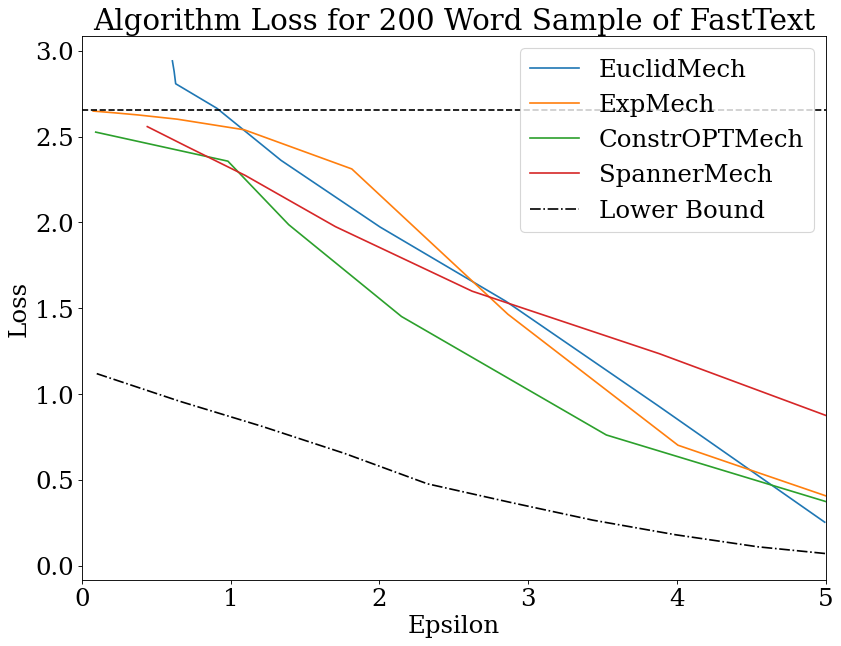

In [18]:
fig, ax = plt.subplots()
ax.set_xlabel('Epsilon')
ax.set_ylabel('Loss')
ax.set_title('Algorithm Loss for 200 Word Sample of FastText')
plot_mech(euclid_data, ax, 0.95, 0.002)
for res in [exp_data, constr_data, span_data]:
    plot_mech(res, ax, 0.95, 0.001)
ax.plot(epsilons_lb, lb, 'k-.', label='Lower Bound')
ax.hlines(np.quantile(emb.distance_matrix.mean(axis=1), 0.95), 0, 5.0, color='k', linestyles='dashed')
ax.set_xlim(0, 5.0)
ax.legend()

In [31]:
np.quantile( np.array(opt_data['time']), 0.5)

8.849445223808289

In [19]:
#Mechanism - Number of variables - Number of constraints
#OPTMech - n^2 - n^3
#ConstOPTMech 

#Work on abstract and get main claims sorted out.
#Upload PNG's of the plots to the overleaf. - Check, but still working on this
#Can we fix a word embedding and show that the utility of one approach is better than another?
#Can we find a word embedding where their approach fails and our approach succeeds? - Yes, see plot below
#Write a paragraph about how we compare to them. Explain their approach in a few sentences.

In [4]:
exp_data = pickle.load(open('data/vary_pts/fasttext/exp_data.pkl', 'rb'))
constr_data = pickle.load(open('data/vary_pts/fasttext/constr_data_10.pkl', 'rb'))
constr_data_5 = pickle.load(open('data/vary_pts/fasttext/constr_data_5.pkl', 'rb'))
spanner_data = pickle.load(open('data/vary_pts/fasttext/spanner_data.pkl', 'rb'))
#spanner_const_data = pickle.load(open('data/vary_pts/fasttext/spanner_const_data_1.3.pkl', 'rb'))
#weight_exp_data = pickle.load(open('data/vary_pts/fasttext/weight_exp_data.pkl', 'rb'))

In [5]:
def multi_point_loss(data, epsilon, utility_quantile, delta=0.001):
    loss = []
    pts = []
    for k, dat in data.items():
        #emb = load_embeddings('data/fasttext_sample_1000_0.5.txt', k)
        if 'utility' in dat and 'trans' in dat:
            m = dat['distance_matrix']
            x = np.array([ get_actual_epsilon(t, m, delta).max() for t in dat['trans']])
            print(x)
            #x = np.array( dat['epsilon'] )
            y = np.array( list(map(lambda x: np.quantile(x, utility_quantile), dat['utility'])) )
            include = correct_data(x,y)
            x = x[include]
            y = y[include]
            if epsilon < x[0] or epsilon > x[-1]:
                print('possible interpolation inconsistency')
                print(epsilon)
                print(x)
            loss.append(np.interp(epsilon, x, y))
            pts.append(k)
    return (pts, loss)

In [8]:
epsilon = 2.0
exp_loss2 = multi_point_loss(exp_data, epsilon, 0.95)
constr_loss2 = multi_point_loss(constr_data, epsilon, 0.95)
constr_loss3 = multi_point_loss(constr_data_5, epsilon, 0.95)
spanner_loss2 = multi_point_loss(spanner_data, epsilon, 0.95)

[2.10045436 2.28575986 2.46747838 2.63893436 2.79977269]
possible interpolation inconsistency
2.0
[2.10045436 2.28575986 2.46747838 2.63893436 2.79977269]
[2.2342405  2.46821982 2.68129295 2.87327541 3.04657567]
possible interpolation inconsistency
2.0
[2.2342405  2.46821982 2.68129295 2.87327541 3.04657567]
[2.28265308 2.51862804 2.7474683  2.9544669  3.13973663]
possible interpolation inconsistency
2.0
[2.28265308 2.51862804 2.7474683  2.9544669  3.13973663]
[2.28709251 2.54409676 2.78342372 3.00167149 3.19739464]
possible interpolation inconsistency
2.0
[2.28709251 2.54409676 2.78342372 3.00167149 3.19739464]
[2.33483709 2.58611842 2.8223443  3.05316016 3.26190405]
possible interpolation inconsistency
2.0
[2.33483709 2.58611842 2.8223443  3.05316016 3.26190405]
[2.35647838 2.62038905 2.86443949 3.08408724 3.29675032]
possible interpolation inconsistency
2.0
[2.35647838 2.62038905 2.86443949 3.08408724 3.29675032]
[2.36150183 2.62983991 2.87994764 3.10690808 3.32631684]
possible inte

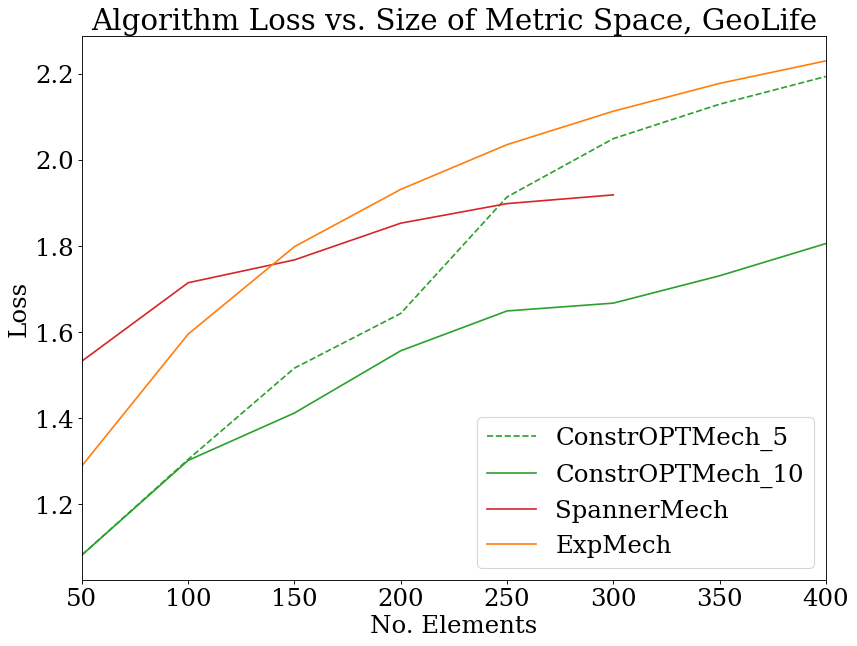

In [9]:
fig, ax = plt.subplots()
ax.plot(*constr_loss3, label=constr_label+'_5', color='tab:green', linestyle='dashed')
ax.plot(*constr_loss2, label=constr_label+'_10', color='tab:green')
ax.plot(*spanner_loss2, label=spanner_label, color='tab:red')
ax.plot(*exp_loss2, label=exp_label, color='tab:orange')
ax.set_xlim(50, 400)
ax.set_xlabel('No. Elements')
ax.set_ylabel('Loss')
ax.set_title('Algorithm Loss vs. Size of Metric Space, GeoLife')
ax.legend()

In [12]:
pts = [50, 150, 300, 400]
ans = ''
for p in pts:
    ans += '%d & ' % p
print(ans[:-2] + '\\\\ \\hline')
ans = ''
for p in pts:
    mem = constr_data[p]['lp_shape'][0][0]
    time = np.quantile(constr_data[p]['time'][0], 0.5)
    ans += '%0.2f sec, \\num{%0.2e} nz & ' % (time, mem)
print(ans[:-2] + '\\\\ \\hline')
ans = ''
for p in pts:
    mem = constr_data_5[p]['lp_shape'][0][0]
    time = np.quantile(constr_data_5[p]['time'][0], 0.5)
    ans += '%0.2f sec, \\num{%0.2e} nz & ' % (time, mem)
print(ans[:-2] + '\\\\ \\hline')
ans = ''
for p in pts[:-1]:
    mem = spanner_data[p]['lp_shape'][0][0]
    if 'time' in spanner_data[p]:
        time = np.quantile(spanner_data[p]['time'][0], 0.5)
        ans += '%0.2f sec, \\num{%0.2e} nz & ' % (time, mem)
    else:
        ans += '-- sec, \\num{%0.2e} nz & ' % (mem)
print(ans[:-2] + '\\\\ \\hline')

50 & 150 & 300 & 400 \\ \hline
1.89 sec, \num{3.23e+04} nz & 24.91 sec, \num{1.47e+05} nz & 163.75 sec, \num{3.79e+05} nz & 234.63 sec, \num{5.71e+05} nz \\ \hline
0.47 sec, \num{1.21e+04} nz & 12.85 sec, \num{6.60e+04} nz & 65.56 sec, \num{2.19e+05} nz & 141.90 sec, \num{3.70e+05} nz \\ \hline
1.25 sec, \num{2.12e+04} nz & 62.16 sec, \num{2.56e+05} nz & 1001.82 sec, \num{1.19e+06} nz \\ \hline
